# Image Restoration

Contents:
- Inverse Filtering
- Wiener Filtering
- Constrained Least-Squares
- Bilateral Filtering
- Non-Local Means

Author: Abijith J. Kamath
https://kamath-abhijith.github.io

In [2]:
import numpy as np

from skimage import io
from scipy.io import loadmat
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import rcParams

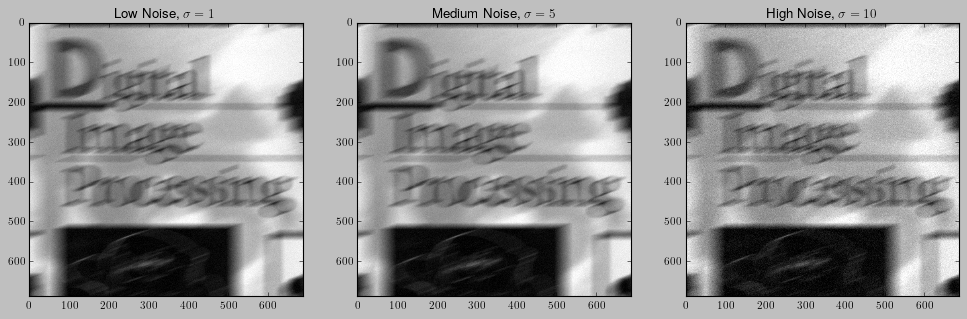

In [13]:
## READ AND DISPLAY IMAGES

low_noise = io.imread("Blurred-LowNoise.png", 0)
med_noise = io.imread("Blurred-MedNoise.png", 0)
high_noise = io.imread("Blurred-HighNoise.png", 0)

blur_kernel = loadmat("BlurKernel.mat")
blur_kernel = blur_kernel['h']

style.use('classic')
rcParams['text.usetex'] = True
rcParams.update({'font.size': 10})
rcParams['text.latex.preamble'] = [r'\usepackage{tgheros}'] 

fig, plts = plt.subplots(1,3,figsize=(15,6))
plts[0].imshow(low_noise, vmin=0, vmax=255, cmap='gray')
plts[0].set_title(r"Low Noise, $\sigma=1$")

plts[1].imshow(med_noise, vmin=0, vmax=255, cmap='gray')
plts[1].set_title(r"Medium Noise, $\sigma=5$")

plts[2].imshow(high_noise, vmin=0, vmax=255,cmap='gray')
plts[2].set_title(r"High Noise, $\sigma=10$")

plt.savefig('/Users/abhijith/Desktop/TECHNOLOGIE/Courses/E9 241 Digital Signal Processing/Assignments/Assignment_4/Answers/figures/disimages.eps', format='eps')
plt.show()

## Inverse Filtering

Let $y$ be a degraded image modelled using the linear forward model, i.e., $f = h*x + w$, where $w$ is independent, white Gaussian noise. The inverse filter method to recover $x$ from $y$ uses the Fourier domain representation. Using DFT,

\begin{equation}
\begin{split}
    Y &= H\cdot X + W \\
    \hat{X} &= \frac{Y}{H}.
\end{split}
\end{equation}

This model is simple to implement bu disregards noise, and hence is not robust to noise.

In [4]:
## FUNCTION DEFINITIONS :: INVERSE FILTERING

def inverse_filter(image, kernel):
    m,n = image.shape

    fft_image = np.fft.fft2(image, (m,n))
    fft_kernel = np.fft.fft2(kernel, (m,n))

    fft_deconv = fft_image/fft_kernel
    deconv = np.fft.ifft2(fft_deconv)

    return np.abs(deconv)

In [5]:
## MAIN :: INVERSE FILTERING

deconv_low_noise = inverse_filter(low_noise, blur_kernel)
deconv_med_noise = inverse_filter(med_noise, blur_kernel)
deconv_high_noise = inverse_filter(high_noise, blur_kernel)

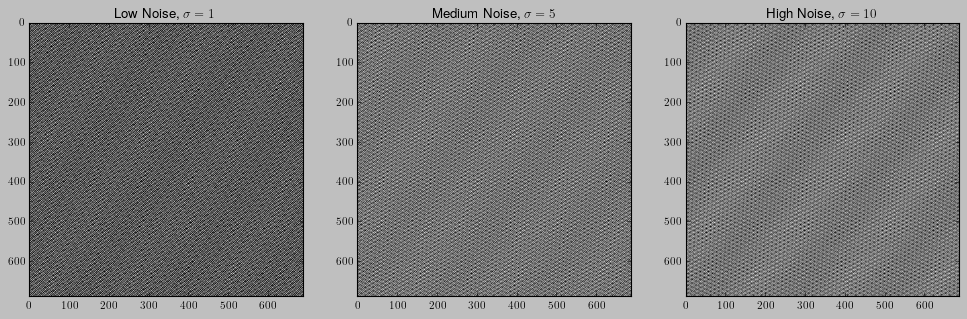

In [6]:
## PLOTS :: INVERSE FILTERING

fig, plts = plt.subplots(1,3,figsize=(15,6))
plts[0].imshow(deconv_low_noise, cmap='gray')
plts[0].set_title(r"Low Noise, $\sigma=1$")

plts[1].imshow(deconv_med_noise, cmap='gray')
plts[1].set_title(r"Medium Noise, $\sigma=5$")

plts[2].imshow(deconv_high_noise, cmap='gray')
plts[2].set_title(r"High Noise, $\sigma=10$")

plt.savefig('/Users/abhijith/Desktop/TECHNOLOGIE/Courses/E9 241 Digital Signal Processing/Assignments/Assignment_4/Answers/figures/invfilter.eps', format='eps')
plt.show()

## Wiener Filtering

Let $y$ be a degraded image modelled using the linear forward model, i.e., $f = h*x + w$, where $w$ is independent, white Gaussian noise. The Wiener filter is a minimises the unconstrained least-sqaures cost between the measurements and the linear model and the Wiener filter solution is:

\begin{equation}
\begin{split}
    \hat{X} = \frac{\vert H\vert^2}{\vert H\vert^2 + SNR^{-1}} \frac{Y}{H},
\end{split}
\end{equation}
that takes into account the noise level in the image. However, since the solution is a least-squares minimiser, the recovered image has smoothing artefacts.

In [7]:
## FUNCTION DEFINITIONS :: WIENER FILTER

def wiener_filter(image, kernel, noise_level):
    m,n = image.shape

    fft_image = np.fft.fft2(image, (m,n))
    fft_kernel = np.fft.fft2(kernel, (m,n))

    snr = noise_level**2
    fft_deconv = np.abs(fft_kernel)**2/(np.abs(fft_kernel)**2 + snr) * fft_image/fft_kernel
    deconv = np.fft.ifft2(fft_deconv)

    return np.abs(deconv)

In [8]:
## MAIN :: WIENER FILTERING

wiener_low_noise = wiener_filter(low_noise, blur_kernel, 1)
wiener_med_noise = wiener_filter(med_noise, blur_kernel, 25)
wiener_high_noise = wiener_filter(high_noise, blur_kernel, 100)

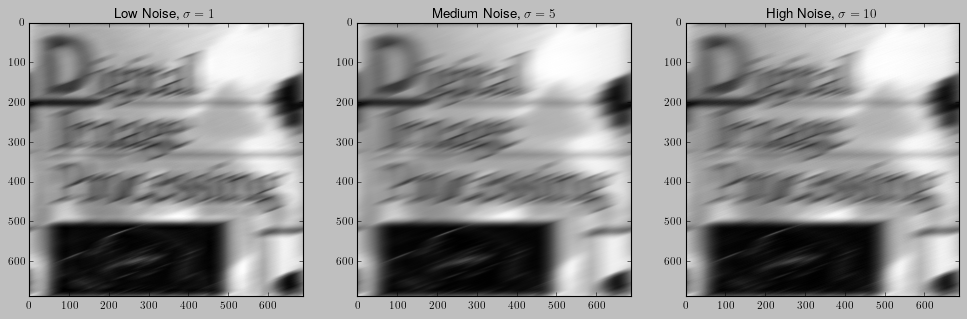

In [14]:
## PLOTS :: WIENER FILTERING

fig, plts = plt.subplots(1,3,figsize=(15,6))
plts[0].imshow(wiener_low_noise, cmap='gray')
plts[0].set_title(r"Low Noise, $\sigma=1$")

plts[1].imshow(wiener_med_noise, cmap='gray')
plts[1].set_title(r"Medium Noise, $\sigma=5$")

plts[2].imshow(wiener_high_noise, cmap='gray')
plts[2].set_title(r"High Noise, $\sigma=10$")

plt.savefig('/Users/abhijith/Desktop/TECHNOLOGIE/Courses/E9 241 Digital Signal Processing/Assignments/Assignment_4/Answers/figures/wienerfilter.eps', format='eps')
plt.show()

## Constrained Least-Squares

Let $y$ be a degraded image modelled using the linear forward model, i.e., $f = h*x + w$, where $w$ is independent, white Gaussian noise. This can be represented in the matrix form as $\mathbf{y} = \mathbf{H}\mathbf{x} + \mathbf{w}$. Constrained least-squares solves the programme:

\begin{equation}
\begin{split}
    \hat{X} = \frac{\vert H\vert^2}{\vert H\vert^2 + \lambda \vert C\vert^2} \frac{Y}{H},
\end{split}
\end{equation}
where $C$ is a constraint based on the image prior and $\lambda >0$ is a penalty parameter.

In [10]:
## FUNCTION DEFINITION :: CONSTRAINED LEAST-SQUARES

def constrained_ls(image, kernel, constraint, lambd):
    m,n = image.shape

    fft_image = np.fft.fft2(image, (m,n))
    fft_kernel = np.fft.fft2(kernel, (m,n))
    fft_constraint = np.fft.fft2(constraint, (m,n))

    fft_deconv = np.abs(fft_kernel)**2/(np.abs(fft_kernel)**2 + lambd*np.abs(fft_constraint)) * fft_image/fft_kernel
    deconv = np.fft.ifft2(fft_deconv)
    
    return np.abs(deconv)

In [18]:
## MAIN :: CONSTRAINED LEAST-SQUARES

C = np.array([[0.0, 0.25, 0.0],
              [0.25, -1.0, 0.25],
              [0.0, 0.25, 0.0]])
lambd = 1
cls_low_noise = constrained_ls(low_noise, blur_kernel, C, lambd)

# lambd = 5
cls_med_noise = constrained_ls(med_noise, blur_kernel, C, lambd)

# lambd = 10
cls_high_noise = constrained_ls(high_noise, blur_kernel, C, lambd)

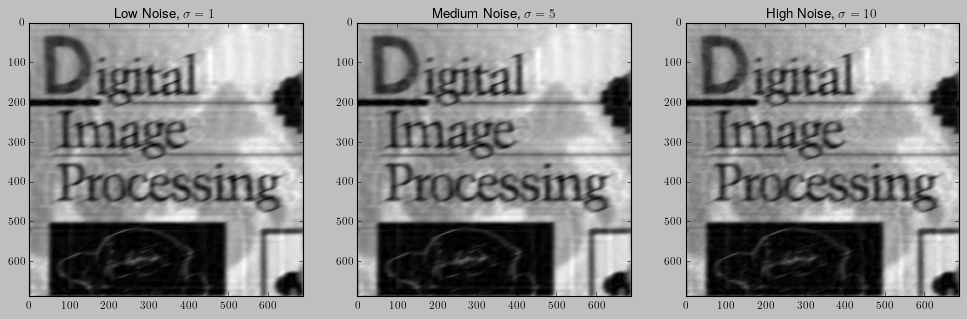

In [19]:
## PLOTS :: CONSTRAINED LEAST-SQUARES

fig, plts = plt.subplots(1,3,figsize=(15,6))
plts[0].imshow(cls_low_noise, cmap='gray')
plts[0].set_title(r"Low Noise, $\sigma=1$")

plts[1].imshow(cls_med_noise, cmap='gray')
plts[1].set_title(r"Medium Noise, $\sigma=5$")

plts[2].imshow(cls_high_noise, cmap='gray')
plts[2].set_title(r"High Noise, $\sigma=10$")

plt.savefig('/Users/abhijith/Desktop/TECHNOLOGIE/Courses/E9 241 Digital Signal Processing/Assignments/Assignment_4/Answers/figures/cls.eps', format='eps')
plt.show()